# Deep Learning Models Comparison On CIFAR10 Dataset Using Cross Validation
The code in this file compares the performance between ResNet18 and my own CNN model on CIFAR10 dataset using corss validation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
jupyter nbconvert --to html ///content/HW4.ipynb

UsageError: Cell magic `%%shell` not found.


In [ ]:

%cd gdrive/MyDrive/Colab\ Notebooks/HW4_Full

/content/gdrive/MyDrive/Colab Notebooks/HW4_Full


In [ ]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6202 sha256=e77c0d25a5ffd36bc67fc7bf9500fe670fecdf5899f8c9a4188e93cd92672361
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch-utils


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
import torchvision.datasets as datasets

from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#Training Method


In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # You can use .cuda() function
            ######################
            ### YOUR CODE HERE ###
            ######################
            model.cuda()
            data = data.cuda()
            target = target.cuda()
            #####################
            ### YOUR CODE END ###
            #####################

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            ######################
            ### YOUR CODE HERE ###
            ######################
            output = model.forward(data)

            #####################
            ### YOUR CODE END ###
            #####################

            # Loss function 
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss = criterion(output,target)
            #####################
            ### YOUR CODE END ###
            #####################

            # Backward path (backpropagation)
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss.backward()
            #####################
            ### YOUR CODE END ###
            #####################

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:

                    # Tensors to gpu
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    model.cuda()
                    data = data.cuda()
                    target = target.cuda()
                    #####################
                    ### YOUR CODE END ###
                    #####################
                    # Forward path
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    output = model.forward(data)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Validation loss computation
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    loss = criterion(output,target)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model 
                    # You can use torch.save()
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    torch.save(model.state_dict(),save_file_name)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        # You can use model.load_state_dict()
                        ######################
                        ### YOUR CODE HERE ###
                        ######################
                        model.load_state_dict(torch.load(save_file_name))
                        #####################
                        ### YOUR CODE END ###
                        #####################

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

#Extract Data from CIFAR10 dataset

In [ ]:

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to CNN N,C,H,W data format
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[3], X_train.shape[2], X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[3], X_val.shape[2], X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[3], X_test.shape[2], X_test.shape[1]))

    return X_train, y_train, X_val, y_val, X_test, y_test






#My CNN Model

In [ ]:
from data_utils import load_CIFAR10
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(6,16,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(16*16*16,84,bias=True)
        self.linear2 = nn.Linear(84,56,bias=True)
        self.linear3 = nn.Linear(56,32,bias=True)
        self.linear4 = nn.Linear(32,10,bias=True)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1,16*16*16)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.1002 	Validation Loss: 1.9568
		Training Accuracy: 23.47%	 Validation Accuracy: 31.00%

Epoch: 1 	Training Loss: 1.8819 	Validation Loss: 1.8011
		Training Accuracy: 32.75%	 Validation Accuracy: 37.60%

Epoch: 2 	Training Loss: 1.7493 	Validation Loss: 1.7088
		Training Accuracy: 37.73%	 Validation Accuracy: 40.60%

Epoch: 3 	Training Loss: 1.6643 	Validation Loss: 1.6273
		Training Accuracy: 40.71%	 Validation Accuracy: 42.80%

Epoch: 4 	Training Loss: 1.6067 	Validation Loss: 1.5970
		Training Accuracy: 43.01%	 Validation Accuracy: 42.00%

Epoch: 5 	Training Loss: 1.5637 	Validation Loss: 1.5633
		Training Accuracy: 44.59%	 Validation Accuracy: 44.10%

Epoch: 6 	Training Loss: 1.5273 	Validation Loss: 1.5310
		Training Accuracy: 45.97%	 Validation Accuracy: 44.10%

Epoch: 7 	Training Loss: 1.4963 	Validation Loss: 1.5506
		Training Accuracy: 47.13%	 Validation Accuracy: 45.00%

Epoch: 8 	Training Loss: 1.4687 	Validation Lo

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

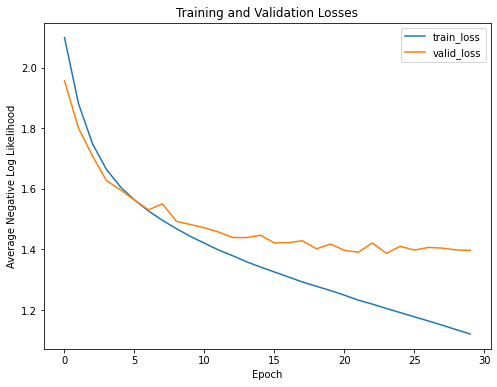

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

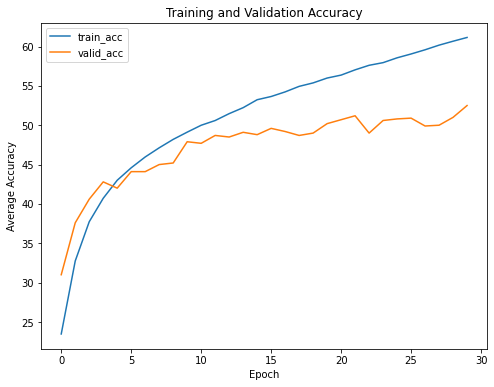

Best accuracy in validation history is 52.5%


In [ ]:




# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)


CNN = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(),lr=1e-4)
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).to(torch.long)),
    'valid':
    TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).to(torch.long))

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=2),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False,num_workers=2)
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape
save_file_name = f'CNN_model_best_model.pt'
train_on_gpu = cuda.is_available()
model, history = train(CNN,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=6,
    n_epochs=500,
    print_every=1)

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()
bestAccVal = max(history['valid_acc'])*100
print('Best accuracy in validation history is {0}%'.format(bestAccVal))




###My CNN Model Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset,SubsetRandomSampler


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_X, train_Y
   del test_X, test_Y
   del validation_X, validation_Y
   print('Clear previously loaded data.')
except:
   pass
# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

num_kFolds = 10
response = {}
num_epochs = 1

criterion = nn.CrossEntropyLoss()

batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).to(torch.long)),
    'valid':
    TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).to(torch.long))

}

ConcatDS = ConcatDataset([data['train'],data['valid']])
kf = KFold(n_splits=num_kFolds,shuffle=True)
CNN = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(),lr=1e-4)
for fold,(train,test) in enumerate(kf.split(ConcatDS)):
  print(f'Fold Number {fold}')
  print('-----------------------------------')
  train_sample = SubsetRandomSampler(train)
  test_sample = SubsetRandomSampler(test) 
  # Dataloader iterators, make sure to shuffle
  dataloaders = {
      'train': DataLoader(ConcatDS, batch_size=batch_size, shuffle=False,num_workers=2, sampler=train_sample),
      'valid': DataLoader(ConcatDS, batch_size=batch_size, shuffle=False,num_workers=2, sampler=test_sample)
  }
  # Iterate through the dataloader once
  trainiter = iter(dataloaders['train'])
  features, labels = next(trainiter)
  features.shape, labels.shape
  save_file_name = f'CNN_model_fold_{fold}.pt'
  train_on_gpu = cuda.is_available()

  for epoch in range(0, num_epochs):
      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(dataloaders['train'], 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = CNN(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
      print('Training process has finished. Saving trained model.')

    # Print about testing
      print('Starting testing')
    
    # Saving the model
      save_path = f'./model-fold-{fold}.pth'
      torch.save(CNN.state_dict(), save_path)

    # Evaluationfor this fold
      correct, total = 0, 0

  with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(dataloaders['valid'], 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = CNN(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      response[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {fold} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in response.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(response.items())} %')



Clear previously loaded data.
Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
Fold Number 0
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 2.288
Loss after mini-batch  1000: 2.179
Loss after mini-batch  1500: 2.122
Loss after mini-batch  2000: 2.083
Loss after mini-batch  2500: 2.050
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 27 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 0 FOLDS
--------------------------------
Fold 0: 27.96 %
Average: 27.96 %
Fold Number 1
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.986
Loss after mini-batch  1000: 1.958
Loss after mini-batch  1500: 1.931
Loss after mini-batch  2000: 1.887
Loss after mini-batch  2500: 1.869
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 1: 32 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 1 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Average: 30.44 %
Fold Number 2
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.830
Loss after mini-batch  1000: 1.802
Loss after mini-batch  1500: 1.796
Loss after mini-batch  2000: 1.791
Loss after mini-batch  2500: 1.776
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 37 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Average: 32.74 %
Fold Number 3
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.734
Loss after mini-batch  1000: 1.734
Loss after mini-batch  1500: 1.719
Loss after mini-batch  2000: 1.721
Loss after mini-batch  2500: 1.711
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 3: 38 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Average: 34.17 %
Fold Number 4
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.679
Loss after mini-batch  1000: 1.688
Loss after mini-batch  1500: 1.676
Loss after mini-batch  2000: 1.654
Loss after mini-batch  2500: 1.654
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 4: 41 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Average: 35.572 %
Fold Number 5
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.639
Loss after mini-batch  1000: 1.644
Loss after mini-batch  1500: 1.625
Loss after mini-batch  2000: 1.622
Loss after mini-batch  2500: 1.623
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 5: 43 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Fold 5: 43.18 %
Average: 36.84 %
Fold Number 6
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.608
Loss after mini-batch  1000: 1.588
Loss after mini-batch  1500: 1.580
Loss after mini-batch  2000: 1.597
Loss after mini-batch  2500: 1.580
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 6: 42 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 6 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Fold 5: 43.18 %
Fold 6: 42.58 %
Average: 37.660000000000004 %
Fold Number 7
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.553
Loss after mini-batch  1000: 1.580
Loss after mini-batch  1500: 1.568
Loss after mini-batch  2000: 1.547
Loss after mini-batch  2500: 1.591
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 7: 45 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Fold 5: 43.18 %
Fold 6: 42.58 %
Fold 7: 45.1 %
Average: 38.59 %
Fold Number 8
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.524
Loss after mini-batch  1000: 1.528
Loss after mini-batch  1500: 1.538
Loss after mini-batch  2000: 1.551
Loss after mini-batch  2500: 1.548
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 8: 45 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 8 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Fold 5: 43.18 %
Fold 6: 42.58 %
Fold 7: 45.1 %
Fold 8: 45.82 %
Average: 39.39333333333334 %
Fold Number 9
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.520
Loss after mini-batch  1000: 1.520
Loss after mini-batch  1500: 1.511
Loss after mini-batch  2000: 1.503
Loss after mini-batch  2500: 1.514
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 9: 47 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 9 FOLDS
--------------------------------
Fold 0: 27.96 %
Fold 1: 32.92 %
Fold 2: 37.34 %
Fold 3: 38.46 %
Fold 4: 41.18 %
Fold 5: 43.18 %
Fold 6: 42.58 %
Fold 7: 45.1 %
Fold 8: 45.82 %
Fold 9: 47.0 %
Average: 40.154 %


#ResNet18

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.8905 	Validation Loss: 1.6645
		Training Accuracy: 32.11%	 Validation Accuracy: 38.70%

Epoch: 1 	Training Loss: 1.6309 	Validation Loss: 1.5094
		Training Accuracy: 40.78%	 Validation Accuracy: 47.40%

Epoch: 2 	Training Loss: 1.5144 	Validation Loss: 1.4665
		Training Accuracy: 45.53%	 Validation Accuracy: 47.10%

Epoch: 3 	Training Loss: 1.4259 	Validation Loss: 1.4394
		Training Accuracy: 49.01%	 Validation Accuracy: 48.70%

Epoch: 4 	Training Loss: 1.3483 	Validation Loss: 1.4636
		Training Accuracy: 51.65%	 Validation Accuracy: 46.10%

Epoch: 5 	Training Loss: 1.2747 	Validation Loss: 1.4474
		Training Accuracy: 54.16%	 Validation Accuracy: 48.90%

Epoch: 6 	Training Loss: 1.2092 	Validation Loss: 1.4324
		Training Accuracy: 56.54%	 Validation Accuracy: 50.80%

Epoch: 7 	Training Loss: 1.1389 	Validation Loss: 1.4340
		Training Accuracy: 59.40%	 Validation Accuracy: 51.20%

Epoch: 8 	Training Loss: 1.0752 	Validation Lo

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

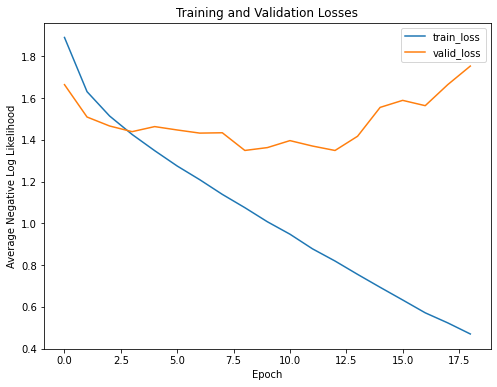

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

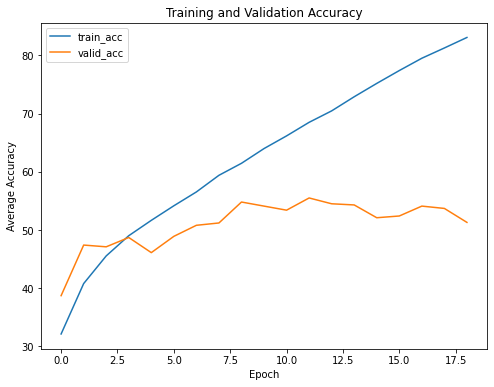

Best accuracy in validation history is 55.50000000000001%


In [ ]:


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_X, train_Y
   del test_X, test_Y
   del validation_X, validation_Y
   print('Clear previously loaded data.')
except:
   pass
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()



# Invoke the above function to get our data.
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)


resnet18 = models.resnet18()
resnet18.fc = nn.Linear(resnet18.fc.in_features,10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(),lr=0.01)
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).to(torch.long)),
    'valid':
    TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).to(torch.long))

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=2),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False,num_workers=2)
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape
save_file_name = f'resnet18_model_best_model.pt'
train_on_gpu = cuda.is_available()
model, history = train(resnet18,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=6,
    n_epochs=500,
    print_every=1)

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()
bestAccVal = max(history['valid_acc'])*100
print('Best accuracy in validation history is {0}%'.format(bestAccVal))




###ResNet-18 Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset,SubsetRandomSampler


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_X, train_Y
   del test_X, test_Y
   del validation_X, validation_Y
   print('Clear previously loaded data.')
except:
   pass
# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

num_kFolds = 10
response = {}
num_epochs = 1

criterion = nn.CrossEntropyLoss()

batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).to(torch.long)),
    'valid':
    TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).to(torch.long))

}

ConcatDS = ConcatDataset([data['train'],data['valid']])
kf = KFold(n_splits=num_kFolds,shuffle=True)
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(resnet18.fc.in_features,10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(),lr=0.01)
for fold,(train,test) in enumerate(kf.split(ConcatDS)):
  print(f'Fold Number {fold}')
  print('-----------------------------------')
  train_sample = SubsetRandomSampler(train)
  test_sample = SubsetRandomSampler(test) 
  # Dataloader iterators, make sure to shuffle
  dataloaders = {
      'train': DataLoader(ConcatDS, batch_size=batch_size, shuffle=False,num_workers=2, sampler=train_sample),
      'valid': DataLoader(ConcatDS, batch_size=batch_size, shuffle=False,num_workers=2, sampler=test_sample)
  }
  # Iterate through the dataloader once
  trainiter = iter(dataloaders['train'])
  features, labels = next(trainiter)
  features.shape, labels.shape
  save_file_name = f'CNN_model_fold_{fold}.pt'
  train_on_gpu = cuda.is_available()

  for epoch in range(0, num_epochs):
      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(dataloaders['train'], 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = resnet18(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
      print('Training process has finished. Saving trained model.')

    # Print about testing
      print('Starting testing')
    
    # Saving the model
      save_path = f'./model-fold-{fold}.pth'
      torch.save(resnet18.state_dict(), save_path)

    # Evaluationfor this fold
      correct, total = 0, 0

  with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(dataloaders['valid'], 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = resnet18(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      response[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {fold} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in response.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(response.items())} %')



Clear previously loaded data.
Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
Fold Number 0
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 2.190
Loss after mini-batch  1000: 2.002
Loss after mini-batch  1500: 1.911
Loss after mini-batch  2000: 1.835
Loss after mini-batch  2500: 1.773
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 35 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 0 FOLDS
--------------------------------
Fold 0: 35.02 %
Average: 35.02 %
Fold Number 1
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.717
Loss after mini-batch  1000: 1.684
Loss after mini-batch  1500: 1.676
Loss after mini-batch  2000: 1.648
Loss after mini-batch  2500: 1.651
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 1: 38 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 1 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Average: 36.67 %
Fold Number 2
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.580
Loss after mini-batch  1000: 1.579
Loss after mini-batch  1500: 1.552
Loss after mini-batch  2000: 1.525
Loss after mini-batch  2500: 1.541
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 42 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Average: 38.626666666666665 %
Fold Number 3
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.472
Loss after mini-batch  1000: 1.450
Loss after mini-batch  1500: 1.436
Loss after mini-batch  2000: 1.455
Loss after mini-batch  2500: 1.450
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 3: 50 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Average: 41.65 %
Fold Number 4
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.367
Loss after mini-batch  1000: 1.389
Loss after mini-batch  1500: 1.354
Loss after mini-batch  2000: 1.373
Loss after mini-batch  2500: 1.377
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 4: 50 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Average: 43.492000000000004 %
Fold Number 5
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.283
Loss after mini-batch  1000: 1.292
Loss after mini-batch  1500: 1.286
Loss after mini-batch  2000: 1.306
Loss after mini-batch  2500: 1.307
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 5: 52 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Fold 5: 52.14 %
Average: 44.93333333333334 %
Fold Number 6
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.217
Loss after mini-batch  1000: 1.251
Loss after mini-batch  1500: 1.228
Loss after mini-batch  2000: 1.223
Loss after mini-batch  2500: 1.224
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 6: 51 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 6 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Fold 5: 52.14 %
Fold 6: 51.88 %
Average: 45.925714285714285 %
Fold Number 7
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.149
Loss after mini-batch  1000: 1.175
Loss after mini-batch  1500: 1.179
Loss after mini-batch  2000: 1.153
Loss after mini-batch  2500: 1.174
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 7: 59 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Fold 5: 52.14 %
Fold 6: 51.88 %
Fold 7: 59.12 %
Average: 47.575 %
Fold Number 8
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.066
Loss after mini-batch  1000: 1.113
Loss after mini-batch  1500: 1.084
Loss after mini-batch  2000: 1.103
Loss after mini-batch  2500: 1.137
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 8: 61 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 8 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Fold 5: 52.14 %
Fold 6: 51.88 %
Fold 7: 59.12 %
Fold 8: 61.82 %
Average: 49.15777777777778 %
Fold Number 9
-----------------------------------


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

Starting epoch 1
Loss after mini-batch   500: 1.019
Loss after mini-batch  1000: 1.030
Loss after mini-batch  1500: 1.040
Loss after mini-batch  2000: 1.055
Loss after mini-batch  2500: 1.079
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 9: 62 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 9 FOLDS
--------------------------------
Fold 0: 35.02 %
Fold 1: 38.32 %
Fold 2: 42.54 %
Fold 3: 50.72 %
Fold 4: 50.86000000000001 %
Fold 5: 52.14 %
Fold 6: 51.88 %
Fold 7: 59.12 %
Fold 8: 61.82 %
Fold 9: 62.56 %
Average: 50.498000000000005 %
